# Apple (AAPL) Options Exploratory Data Analysis

Using Dolt, we obtain Apple options data from Feb 2019 to late Jan 2025. We consider vega (which is about implied volatility), arbitrage, and seeing if there's any trends as the date-to-expiration draws near.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
df = pd.read_csv('options/aapl_option_chain.csv', encoding='utf-8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112394 entries, 0 to 112393
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        112394 non-null  object 
 1   act_symbol  112394 non-null  object 
 2   expiration  112394 non-null  object 
 3   strike      112394 non-null  float64
 4   call_put    112394 non-null  object 
 5   bid         112394 non-null  float64
 6   ask         112394 non-null  float64
 7   vol         112394 non-null  float64
 8   delta       112394 non-null  float64
 9   gamma       112394 non-null  float64
 10  theta       112394 non-null  float64
 11  vega        112394 non-null  float64
 12  rho         112394 non-null  float64
dtypes: float64(9), object(4)
memory usage: 11.1+ MB


In [5]:
len(df[df['date'] == '2019-02-09'])

66

In [3]:
df.head(67)

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
0,2019-02-09,AAPL,2019-02-22,145.0,Call,25.30,26.05,0.4236,0.9773,0.0038,-0.0371,0.0180,0.0540
1,2019-02-09,AAPL,2019-02-22,145.0,Put,0.06,0.08,0.3886,-0.0149,0.0029,-0.0172,0.0125,-0.0010
2,2019-02-09,AAPL,2019-02-22,152.5,Call,17.90,18.55,0.3267,0.9627,0.0075,-0.0419,0.0271,0.0559
3,2019-02-09,AAPL,2019-02-22,152.5,Put,0.12,0.16,0.3166,-0.0330,0.0070,-0.0274,0.0246,-0.0022
4,2019-02-09,AAPL,2019-02-22,157.5,Call,13.30,13.55,0.2950,0.9208,0.0150,-0.0619,0.0492,0.0550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2019-02-09,AAPL,2019-03-29,187.5,Call,0.88,0.96,0.2211,0.1364,0.0158,-0.0324,0.1364,0.0299
63,2019-02-09,AAPL,2019-03-29,187.5,Put,17.30,17.60,0.2091,-0.8999,0.0170,-0.0174,0.1105,-0.0922
64,2019-02-09,AAPL,2019-03-29,195.0,Call,0.34,0.39,0.2265,0.0616,0.0086,-0.0183,0.0759,0.0136
65,2019-02-09,AAPL,2019-03-29,195.0,Put,24.40,24.70,0.2265,-0.9660,0.0101,-0.0070,0.0506,-0.0445


In [5]:
# Ensure 'date' and 'expiration' are in datetime format
df['date'] = pd.to_datetime(df['date'])
df['expiration'] = pd.to_datetime(df['expiration'])

# Calculate time to expiration in days
df['time_to_expiration'] = (df['expiration'] - df['date']).dt.days

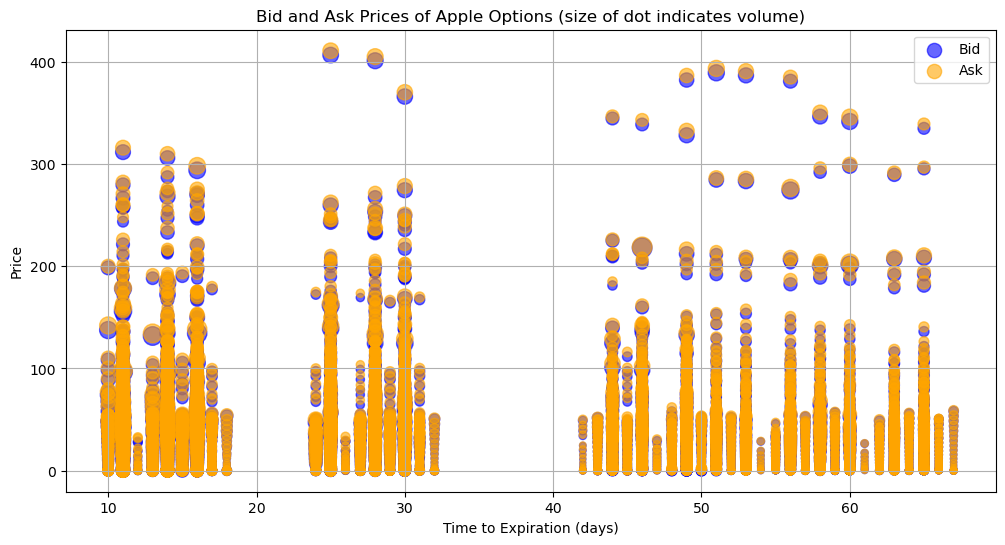

In [6]:
# Normalize volume for marker size (scale between 10 and 200 for better visibility)
df['volume_size'] = np.interp(df['vol'], (df['vol'].min(), df['vol'].max()), (10, 200))

# Filter data for call options (optional)
filtered_df = df[df['call_put'] == 'Call']

# Plot Bid and Ask with marker size based on volume
plt.figure(figsize=(12, 6))

# Plot Bid prices
plt.scatter(
    filtered_df['time_to_expiration'], 
    filtered_df['bid'], 
    s=filtered_df['volume_size'],  # Marker size by volume
    alpha=0.6, 
    color='blue', 
    label='Bid'
)

# Plot Ask prices
plt.scatter(
    filtered_df['time_to_expiration'], 
    filtered_df['ask'], 
    s=filtered_df['volume_size'],  # Marker size by volume
    alpha=0.6, 
    color='orange', 
    label='Ask'
)

# Add labels, title, legend, and grid
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Price')
plt.title('Bid and Ask Prices of Apple Options (size of dot indicates volume)')
plt.legend()
plt.grid()
plt.show()

Vega ($V$) is the amount that an option contract's price reacts to a 1% change in the underlying asset's implied volatility.

See this [link](https://www.investopedia.com/terms/v/vega.asp)

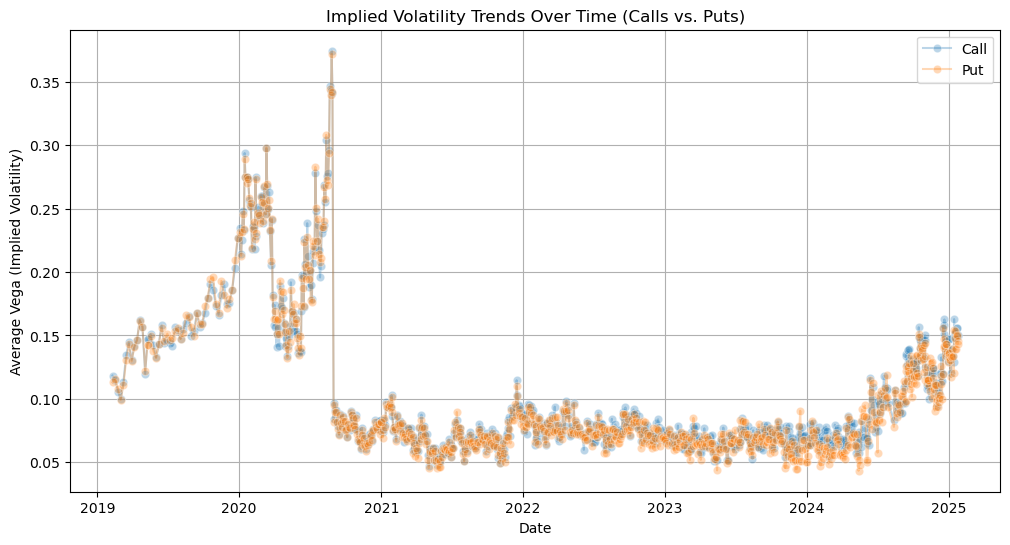

In [10]:
# Filter for relevant columns to simplify
df_filtered = df[['date', 'time_to_expiration', 'vega', 'call_put']].copy()

# Convert 'date' to datetime if not already done
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and call_put to calculate mean vega
mean_vega = df_filtered.groupby(['date', 'call_put'])['vega'].mean().reset_index()

# Plot vega (change) over time for calls and puts
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_vega, x='date', y='vega', hue='call_put', marker='o',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Vega (Implied Volatility)')
plt.title('Implied Volatility Trends Over Time (Calls vs. Puts)')
plt.legend()
plt.grid()
plt.show()


Arbitrage: taking advantage of price discrepancies in the market to make a risk-free profit. It typically involves identifying inefficiencies where an asset is underpriced in one market or format and simultaneously overpriced in another, allowing traders to buy low and sell high instantly.

Looking at the difference between bid and ask may suggest some inefficiencies where the asset is under/overpriced.

In [11]:
# Calculate the bid-ask spread and add it as a new column
df['bid_ask_spread'] = df['ask'] - df['bid'] # just the difference

# Filter out negative or zero spreads (if any data issues exist)
df = df[df['bid_ask_spread'] > 0]

# Summary statistics for spreads
spread_summary = df['bid_ask_spread'].describe()
print("Bid-Ask Spread Summary:")
print(spread_summary)

Bid-Ask Spread Summary:
count    112220.000000
mean          0.669834
std           1.012898
min           0.010000
25%           0.040000
50%           0.200000
75%           0.850000
max           5.000000
Name: bid_ask_spread, dtype: float64


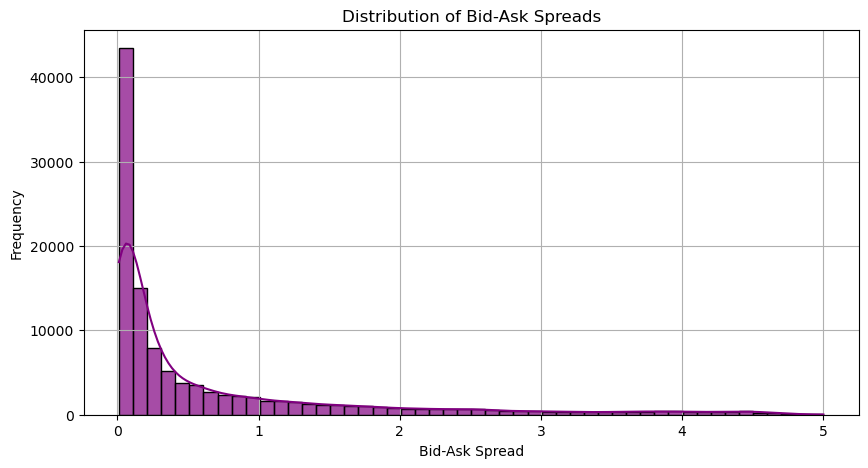

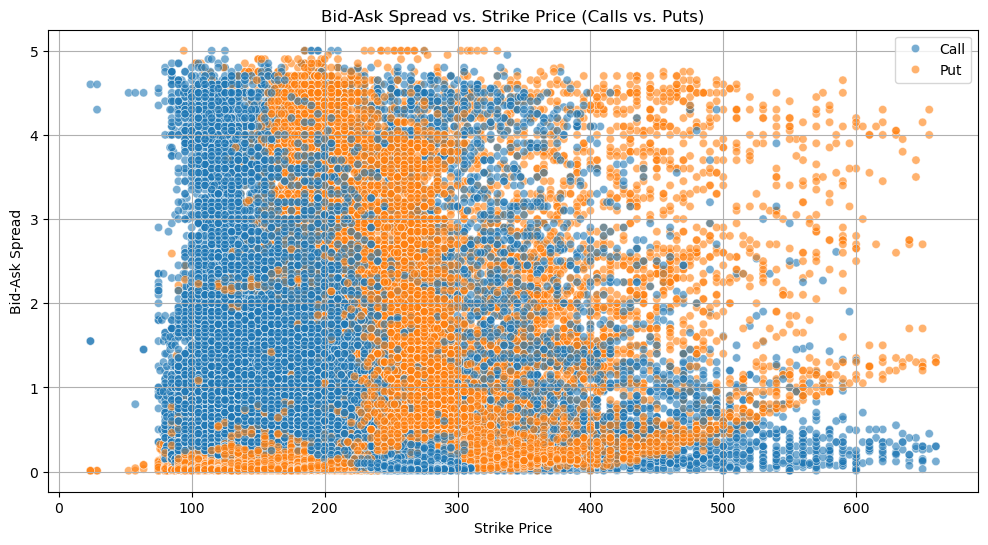

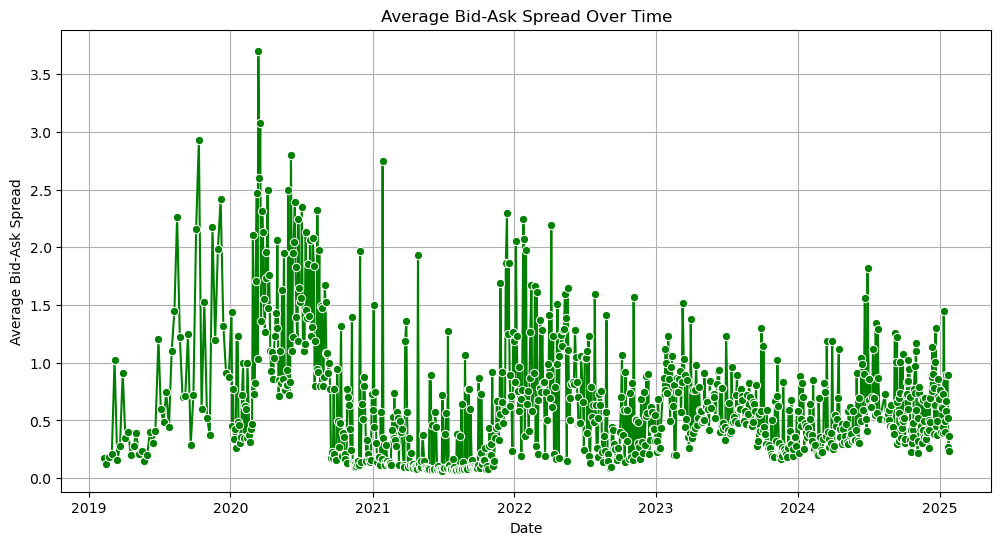

In [13]:
# plot 1: Spread distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['bid_ask_spread'], bins=50, kde=True, color='purple', alpha=0.7)
plt.xlabel('Bid-Ask Spread')
plt.ylabel('Frequency')
plt.title('Distribution of Bid-Ask Spreads')
plt.grid()
plt.show()

# plot 2: Spread by strike price
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df, 
    x='strike', 
    y='bid_ask_spread', 
    hue='call_put', 
    alpha=0.6
)
plt.xlabel('Strike Price')
plt.ylabel('Bid-Ask Spread')
plt.title('Bid-Ask Spread vs. Strike Price (Calls vs. Puts)')
plt.legend()
plt.grid()
plt.show()

# plot 3: Spread over time
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime type
mean_spread = df.groupby('date')['bid_ask_spread'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_spread, x='date', y='bid_ask_spread', color='green', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Bid-Ask Spread')
plt.title('Average Bid-Ask Spread Over Time')
plt.grid()
plt.show()

In [16]:
df.sample()

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho,time_to_expiration,volume_size,bid_ask_spread
40190,2021-10-25,AAPL,2021-12-17,155.0,Call,2.56,2.6,0.2262,0.3234,0.0281,-0.0435,0.2032,0.066,53,24.293329,0.04


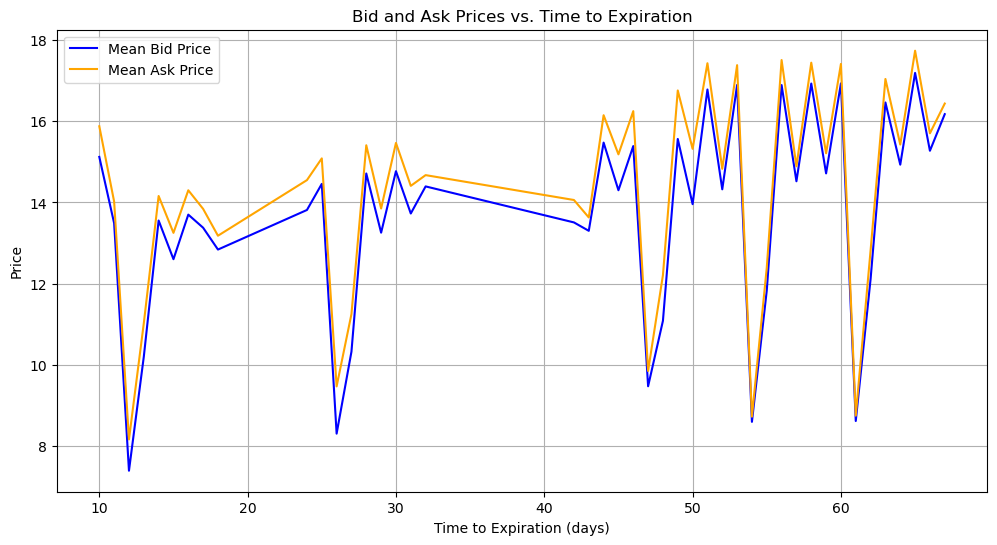

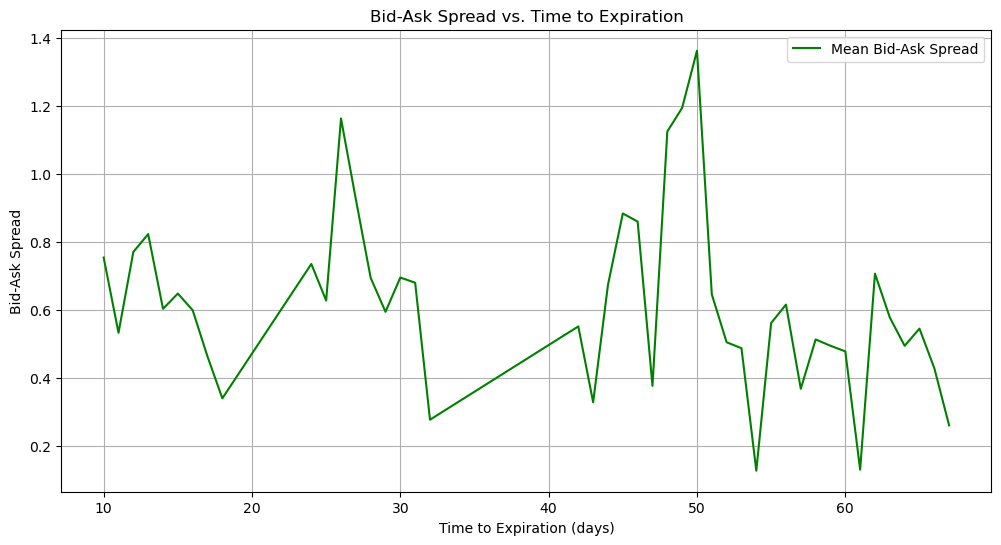

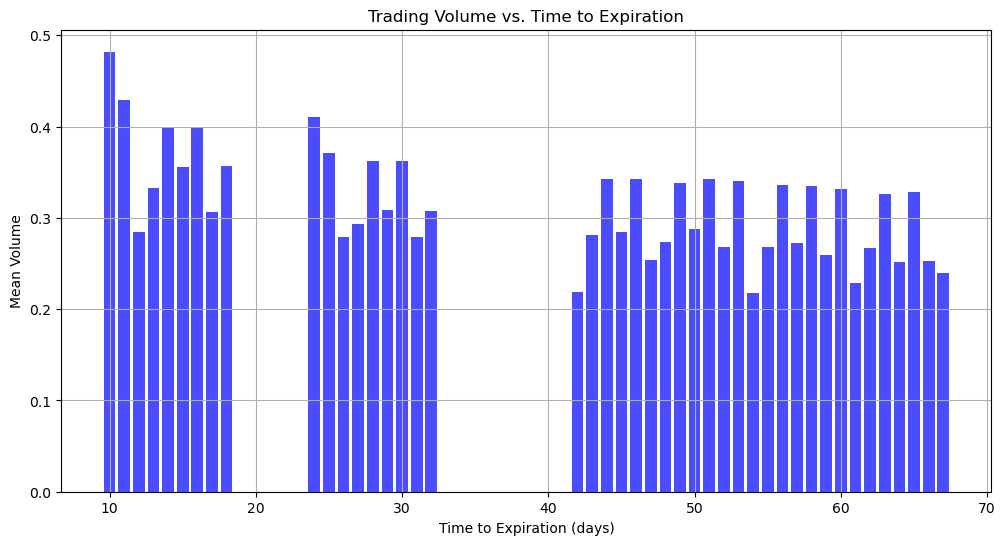

In [18]:
# Group data by 'time_to_expiration' and calculate mean bid, ask, and volume
expiration_dynamics = df.groupby('time_to_expiration').agg(
    mean_bid=('bid', 'mean'),
    mean_ask=('ask', 'mean'),
    mean_volume=('vol', 'mean'),
    spread=('bid_ask_spread', 'mean')
).reset_index()

# Plot 1: Bid and Ask Prices vs. Time to Expiration
plt.figure(figsize=(12, 6))
plt.plot(expiration_dynamics['time_to_expiration'], expiration_dynamics['mean_bid'], label='Mean Bid Price', color='blue')
plt.plot(expiration_dynamics['time_to_expiration'], expiration_dynamics['mean_ask'], label='Mean Ask Price', color='orange')
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Price')
plt.title('Bid and Ask Prices vs. Time to Expiration')
plt.legend()
plt.grid()
plt.show()

# Plot 2: Bid-Ask Spread vs. Time to Expiration
plt.figure(figsize=(12, 6))
plt.plot(expiration_dynamics['time_to_expiration'], expiration_dynamics['spread'], label='Mean Bid-Ask Spread', color='green')
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Bid-Ask Spread')
plt.title('Bid-Ask Spread vs. Time to Expiration')
plt.legend()
plt.grid()
plt.show()

# Plot 3: Volume vs. Time to Expiration
plt.figure(figsize=(12, 6))
plt.bar(expiration_dynamics['time_to_expiration'], expiration_dynamics['mean_volume'], color='blue', alpha=0.7)
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Mean Volume')
plt.title('Trading Volume vs. Time to Expiration')
plt.grid()
plt.show()
